In [3]:
import numpy as np
import matplotlib.pyplot as plt
import dxchange
import h5py

# Reading NFP reconstructed probes from ID16A and save to tiffs (if not done previously)

In [2]:
# n = 2048
# nz = 2048
# prb = np.zeros([4,nz,n],dtype='complex64')    
# for k in range(4):
#         with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/recon/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}_run01.cxi','r') as fid:
#             prb[k]=fid['/entry_1/probe/data'][0,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
# dxchange.write_tiff(np.abs(prb),'data/prb_id16a/prb_abs_2048',overwrite=True)
# dxchange.write_tiff(np.angle(prb),'data/prb_id16a/prb_phase_2048',overwrite=True)

# Propagation of probes from plane 'st' to 'end', and comparison with the NFP reconstruction

In [7]:
st = 0 # plane id to be propagated
end = 3 # plane id to where propagate  
n = 2048
nz = 2048
# ID16a setup
voxelsize = 1e-6*2048/n # [cm] object voxel size 
energy = 33.35  # [keV] x-ray energy    
sx0 = 0.037 # [cm] motor offset from the focal spot
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0 # distances between planes and the focal spot
focusToDetectorDistance = z1[end] # [cm] assume the 'end' plane is the detector
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes
d = distances[st]

prb = np.zeros([len(distances),nz,n],dtype='complex64')    
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')
prb[:] = prb_abs*np.exp(1j*prb_phase)    

0.07870257303127719
[0.24055 0.22245 0.15015 0.     ]


# Propagation with the Fresnel transform and comparison with NFP results

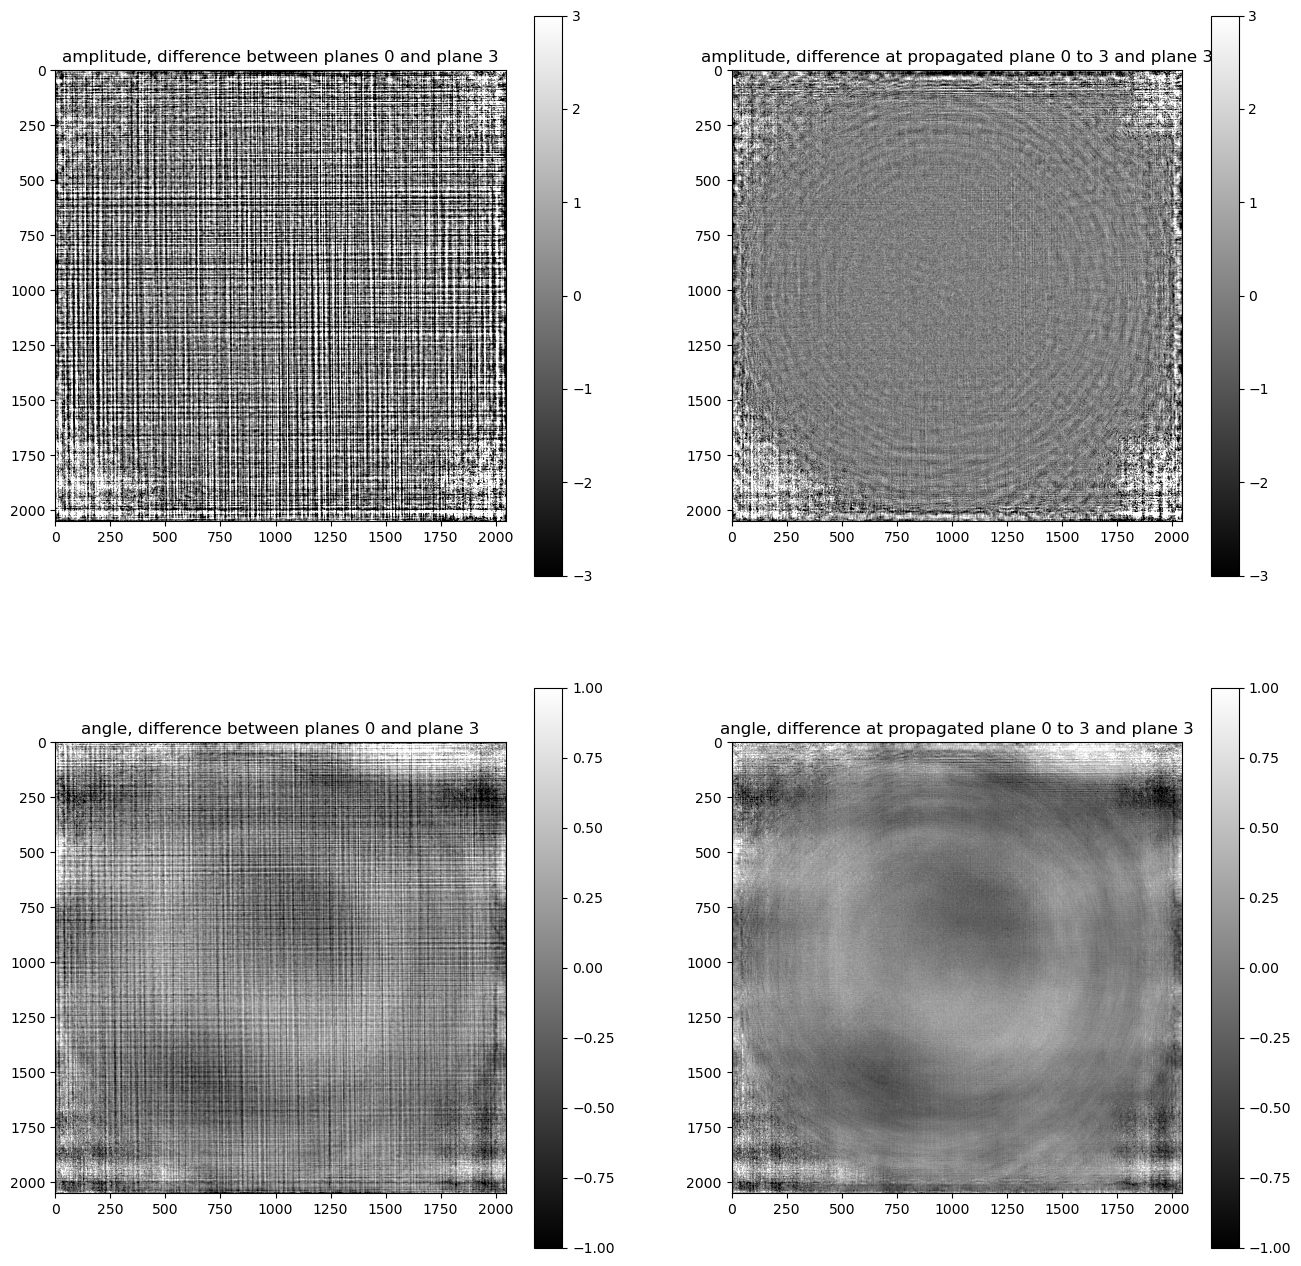

In [6]:
fx = np.fft.fftshift(np.fft.fftfreq(n,d=voxelsize))
[fx,fy] = np.meshgrid(fx,fx)
fP = np.exp(-1j*np.pi*wavelength*d*(fx**2+fy**2))
ff = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(prb[st])))*fP
ff = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ff)))

#
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
im=axs[0,0].imshow(np.abs(prb[st])-np.abs(prb[end]),cmap='gray',vmax=3,vmin=-3)
axs[0,0].set_title(f'amplitude, difference between planes {st} and plane {end}')
fig.colorbar(im)
im=axs[0,1].imshow(np.abs(ff)-np.abs(prb[end]),cmap='gray',vmax=3,vmin=-3)
axs[0,1].set_title(f'amplitude, difference at propagated plane {st} to {end} and plane {end}')
fig.colorbar(im)

im=axs[1,0].imshow(np.angle(prb[st])-np.angle(prb[end]),cmap='gray',vmax=1,vmin=-1)
axs[1,0].set_title(f'angle, difference between planes {st} and plane {end}')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(ff)-np.angle(prb[end]),cmap='gray',vmax=1,vmin=-1)
axs[1,1].set_title(f'angle, difference at propagated plane {st} to {end} and plane {end}')
fig.colorbar(im)
plt.show()

# Make probes for size 384 and voxel size 1e-6*2048/384 - for simple tests

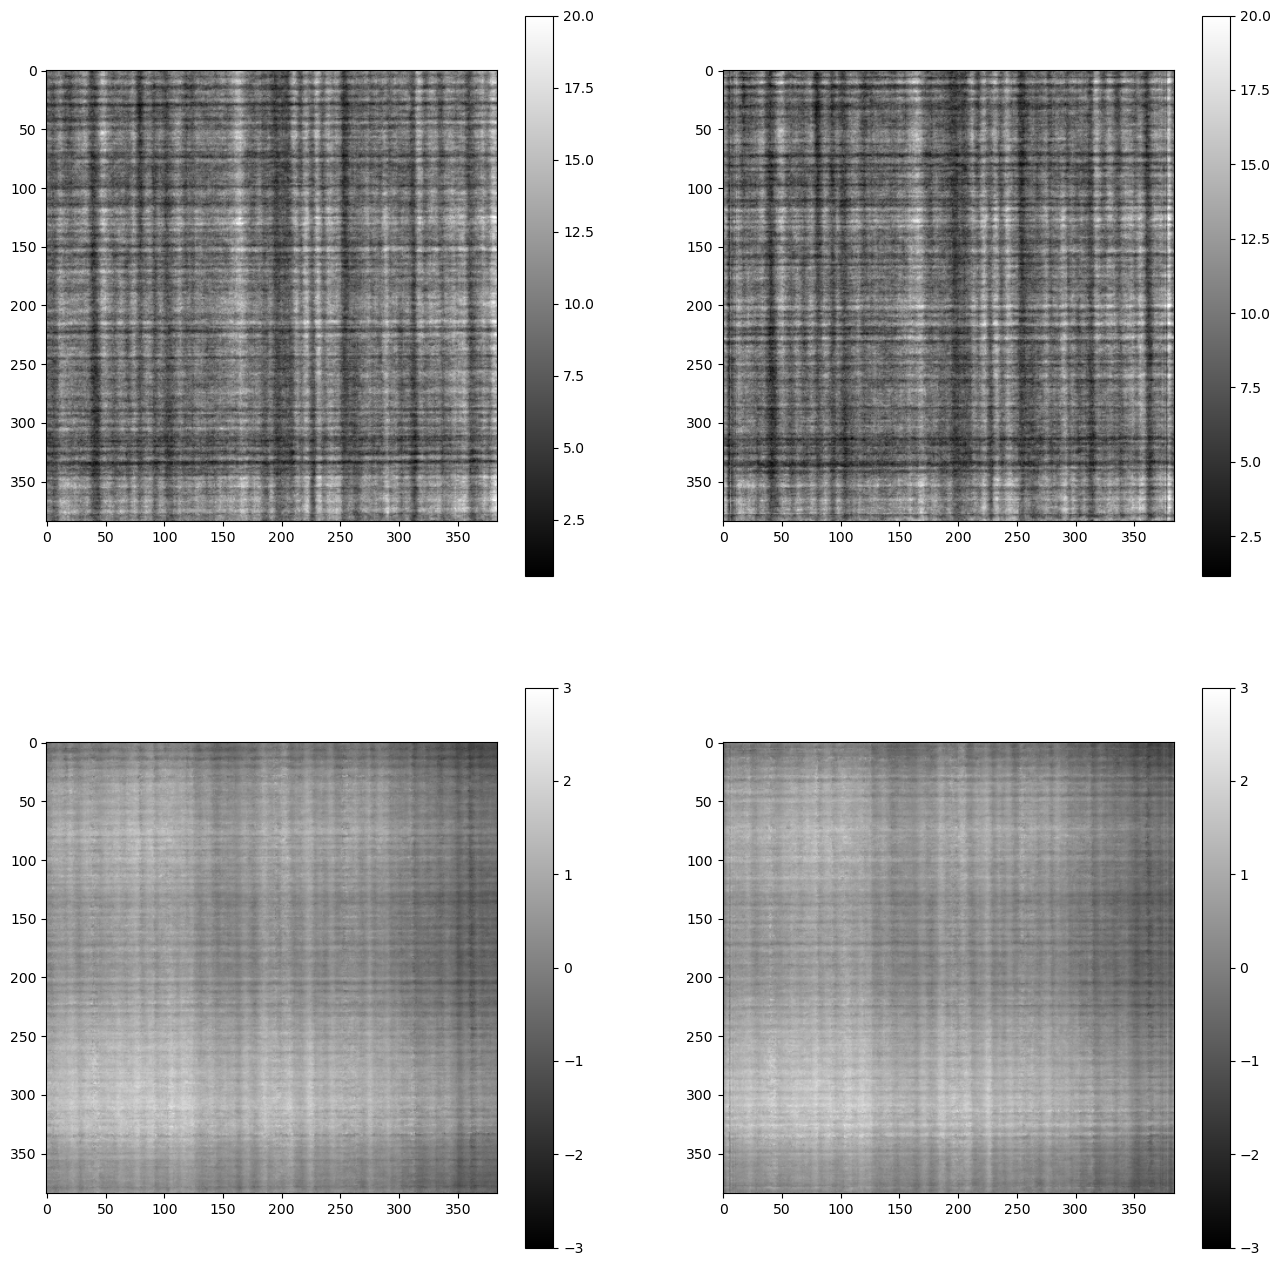

In [4]:
n = 384
nz = 384
sx0 = 0.037
voxelsize = 1e-6*2048/n
wavelength = 1.23984198e-7/33.35
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0

prb = np.zeros([4,nz,n],dtype='complex64')    
prb_abs = dxchange.read_tiff('data/prb_id16a/prb_abs_2048.tiff')[0,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb_phase = dxchange.read_tiff('data/prb_id16a/prb_phase_2048.tiff')[0,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb[0] = prb_abs*np.exp(1j*prb_phase)    

for k in range(4):
    focusToDetectorDistance = z1[k]
    z2 = focusToDetectorDistance-z1
    magnifications = focusToDetectorDistance/z1    
    norm_magnifications = magnifications/magnifications[0]
    distances = (z1*z2)/focusToDetectorDistance*norm_magnifications**2
    d = distances[0]

    fx = np.fft.fftshift(np.fft.fftfreq(n,d=voxelsize))
    [fx,fy] = np.meshgrid(fx,fx)
    fP = np.exp(-1j*np.pi*wavelength*d*(fx**2+fy**2))

    ff=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(prb[0])))*fP
    prb[k]=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ff)))


fig, axs = plt.subplots(2, 2, figsize=(16, 16))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray',vmax=20)
fig.colorbar(im)
im=axs[0,1].imshow(np.abs(prb[-1]),cmap='gray',vmax=20)
fig.colorbar(im)

im=axs[1,0].imshow(np.angle(prb[0]),cmap='gray',vmax=3,vmin=-3)
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray',vmax=3,vmin=-3)
fig.colorbar(im)

plt.show()

# dxchange.write_tiff(np.abs(prb),'data/prb_id16a/prb_abs_384',overwrite=True)
# dxchange.write_tiff(np.angle(prb),'data/prb_id16a/prb_phase_384',overwrite=True)

# Propagation with the Fresnel transform and comparison with NFP results

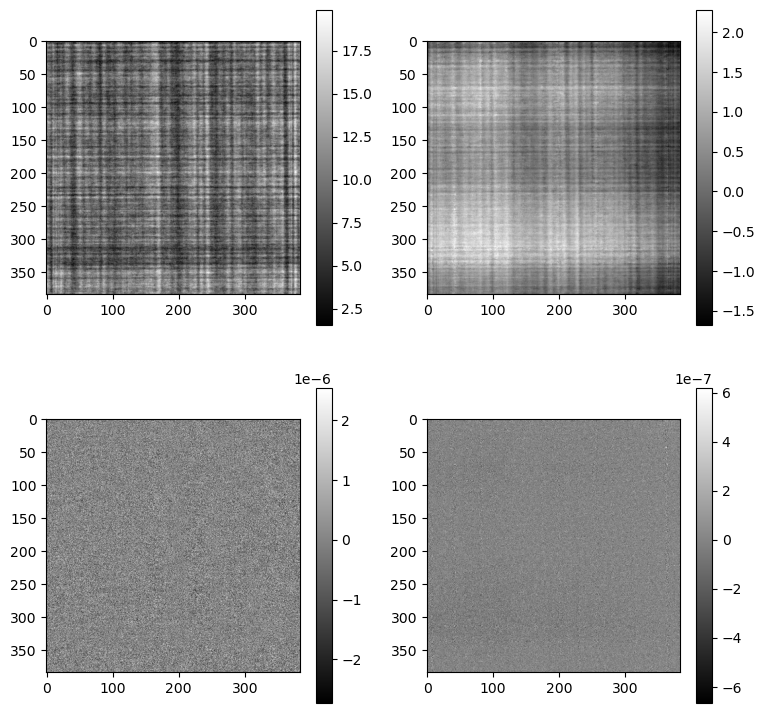

In [8]:
n = 384
nz = 384
sx0 = 0.037
voxelsize = 1e-6*2048/n
wavelength = 1.23984198e-7/33.35
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0
focusToDetectorDistance = 128
z2 = focusToDetectorDistance-z1
magnifications = focusToDetectorDistance/z1    
norm_magnifications = magnifications/magnifications[0]
distances = (z1*z2)/focusToDetectorDistance*norm_magnifications**2
d = distances

prb = np.zeros([len(distances),nz,n],dtype='complex64')    
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')
prb[:] = prb_abs*np.exp(1j*prb_phase)  

fx = np.fft.fftshift(np.fft.fftfreq(n,d=voxelsize))
[fx,fy] = np.meshgrid(fx,fx)
fP = np.exp(-1j*np.pi*wavelength*d[:,np.newaxis,np.newaxis]*(fx**2+fy**2))

ff=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(prb)))*fP
ff=np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ff)))

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(ff[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(ff[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(ff[0])-np.abs(ff[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(ff[0])-np.angle(ff[-1]),cmap='gray')
fig.colorbar(im)